In [2]:
# INSTALL & IMPORT:
!pip install pandas 
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib 
!pip install numpy
!pip install tensorflow 

import os
from IPython.display import FileLink
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix

In [63]:
train_data = pd.read_csv("/home/jovyan/Train data.csv", index_col="Id")
test_data = pd.read_csv("/home/jovyan/Test data.csv", index_col="Id")

# DATA VARIABLE ANALYSIS

##### Definitions of the variables and the nature of the dataframe.


In [19]:
train_data.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [57]:
print("Variable types in the data:")
print(train_data.dtypes)
print("\n")
print('The shape of the data:', train_data.shape)
print("\n")

Variable types in the data:
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object


The shape of the data: (1460, 80)





The data we have consists of 80 variables both categorical and numerical with 1460 rows, where one is the dependent variable and the rest of the vairables are explanatory. 
However, for the sake of efficiency and good ML practise, not all variables will be used. For this project, only columns that are numerical and categorical columns with cardinality that is less than 10 will be utilised for the sake of the preprocessing stage (one-hot encoding).   

# DATA CLEANING

#### 1. Missing values:

In [64]:
miss_value_cols = [col for col in train_data.columns if train_data[col].isnull().any()] #Fetching the names of any columns with missing entries.
print("These are the columns with missing values along with the number of missing values: \n \n", miss_value_cols)     # Printing the names.
print("\n")
missing_value_cols = train_data.isnull().sum()  # Finding the number of missing entries from each column.
missing_value_cols = missing_value_cols[missing_value_cols > 0]
print(missing_value_cols)   # Printing the names and the statistics.

These are the columns with missing values along with the number of missing values: 
 
 ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


It appears there are alot of missing values present within the data.

##### Strategy: 
For this data, the plan is to first remove the rows with missing values in the dependent column. For the numerical columns, the average of each column will be imputed in the respective column where values are missing. For the categorical columns, after the preprocessing part, will be imputed with the most frequent value in the respective columns. The same will be done for the test data, except for removing the dependent column since it does not have that.

### 2. Preprocessing stage:

In [65]:
y = train_data['SalePrice']
train_data.drop(['SalePrice'], axis=1, inplace=True)

In [66]:
train_x, valid_x, train_y, valid_y = tts(train_data,y, train_size = 0.7, random_state = 9)
num_cols = [col for col in train_x.columns if train_x[col].dtype in ['float64', 'int64']]
cat_cols = [col for col in train_x.columns if train_x[col].dtype == 'object' and train_x[col].nunique() < 10]  # Fixed the comparison of dtype and function call

In [67]:
my_cols = num_cols + cat_cols
x_train = train_x[my_cols].copy()
x_valid = valid_x[my_cols].copy()
x_test  = test_data[my_cols].copy()

cat_transformer = Pipeline(steps=[('Impute', SimpleImputer(strategy='most_frequent')),  # Fixed the missing bracket
                                  ('OH', OneHotEncoder(handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[('num', SimpleImputer(strategy='mean'), num_cols),
                                              ('cat', cat_transformer, cat_cols)])

############ ALTERNATIVELY (if we we chose all numerical and categorical columns, we would just write):
# transformer = ColumnTransformer(transformers=[('num', SimpleImputer(strategy='mean'), dtypes_include = np.number),
#                                             ('cat', cat_transformer, dtype_include = object]) 
#                   OR (using make_column_transformer) more straight forward, less configuration :
# transformer = make_column_transformer(
#               (SimpleImputer(strategy='mean'), make_column_selector(dtype_include = np.number)), for numerical columns.
#               (cat_transformer, make_column_selector(dtype_include = object)),                 for categorical columns
# )


transformer.fit(x_train)  # Fit only on training data
x_train_transformed = transformer.transform(x_train)
x_valid_transformed = transformer.transform(x_valid)

# Convert transformed arrays back to DataFrame

x_train_transformed = pd.DataFrame(x_train_transformed, 
                                   columns=transformer.get_feature_names_out(), 
                                   index=x_train.index)
x_valid_transformed = pd.DataFrame(x_valid_transformed, 
                                   columns=transformer.get_feature_names_out(), 
                                   index=x_valid.index)
train_y = train_y.loc[x_train.index]

# FOR THE TEST DATA
x_test_transformed = transformer.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, 
                                  columns=transformer.get_feature_names_out(), 
                                  index=x_test.index)
valid_y = valid_y.loc[x_valid.index]

# EXPLANATORY DATA ANALYSIS

##### Exploring the relationships between the variables.

In [69]:
print("Variable types in the data:")
print(x_train_transformed.dtypes)
print("\n")
print('The shape of the data:', x_train_transformed.shape)
print("\n")

Variable types in the data:
num__MSSubClass               float64
num__LotFrontage              float64
num__LotArea                  float64
num__OverallQual              float64
num__OverallCond              float64
                               ...   
cat__SaleCondition_AdjLand    float64
cat__SaleCondition_Alloca     float64
cat__SaleCondition_Family     float64
cat__SaleCondition_Normal     float64
cat__SaleCondition_Partial    float64
Length: 228, dtype: object


The shape of the data: (1021, 228)




##### In this newly transformed data, we have 226 columns which make it hard to read plots such as heatmaps (It was plotted then excluded here), so the best action (in this project) is to omit the EDA stage with hopes (bad practice) that we will get great results from our validation phase.

# MODEL SELECTION / VALIDATION ANALYSIS

##### Here we are going to try various models and metrics to see which model is the best for predictions.

In [70]:
tree = dtr(random_state = 0)
tree.fit(x_train_transformed, train_y)
tree_predictions = tree.predict(x_valid_transformed)
print("The mean square error for this tree model is: ", mae(tree_predictions,valid_y))

The mean square error for this tree model is:  27274.717539863326


In [72]:
forest_1 = rfr(n_estimators=50, random_state=0)
forest_2 = rfr(n_estimators=100, random_state=0)
forest_3 = rfr(n_estimators=100, criterion='absolute_error', random_state=0)
forest_4 = rfr(n_estimators=200, min_samples_split=20, random_state=0)
forest_5 = rfr(n_estimators=100, max_depth=7, random_state=0)

models = [forest_1, forest_2, forest_3, forest_4, forest_5]

In [26]:
scores = [0,0,0,0,0]
i = 0
acc  = [0,0,0,0,0]
f1   = [0,0,0,0,0]
prec = [0,0,0,0,0]
rec  = [0,0,0,0,0]
for model in models:
    model.fit(x_train_transformed, train_y)
    forest_predictions = model.predict(x_valid_transformed)
    scores[i] = mae(forest_predictions, valid_y)
    acc[i] = accuracy_score(y_true=y_test,y_pred=y_pred)
    f1[i] = f1_score(y_true=y_test,y_pred=y_pred)
    prec[i] = precision_score(y_true=y_test,y_pred=y_pred)
    rec[i] = recall_score(y_true=y_test,y_pred=y_pred)
    i +=1
    
print("For the random forest trees the mean absolute error values are:")
for k in [1,2,3,4,5]:
    print("Random Forest model ", k, ":\t", scores[k-1]) 


For the random forest trees the mean square absolute values are:
Random Forest model  1 :	 17809.410684931507
Random Forest model  2 :	 17612.84342465753
Random Forest model  3 :	 17853.850325342464
Random Forest model  4 :	 18130.819020208157
Random Forest model  5 :	 18299.191403133722


In [ ]:
result = pd.DataFrame([["Random Forest 1",acc[1],f1[1],prec[1],rec[1]]],columns=['Model','Accuracy','F1 score', 'Precision score','Recall score'])
for k in [2,3,4,5]:
    model_result = pd.DataFrame([[" Random Forest " + str(k),acc[1],f1[1],prec[1],rec[1]]],columns=['Model','Accuracy','F1 score', 'Precision score','Recall score'])
    result = pd.concat([model_result,result], ignore_index=True)
    

<Axes: >

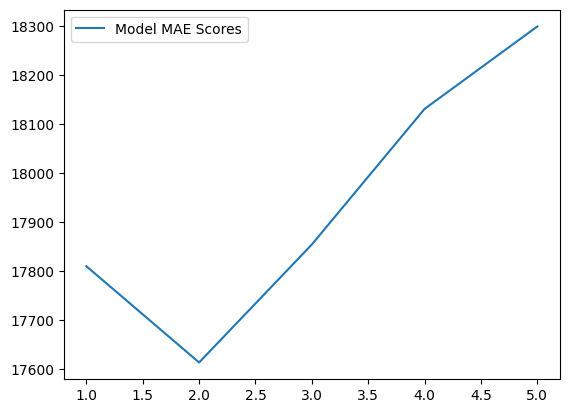

In [32]:
scores_df = pd.DataFrame(scores)
scores_df.index = scores_df.index + 1
scores_df.rename(columns={0: 'Model MAE Scores'}, inplace=True)
scores_df.head()
scores_df.loc[:, ['Model MAE Scores']].plot()

In [ ]:
#### measure performance 

#### It is clear that the best model for the data is model 2 which gives the lowest mae value out of all the models.

In [ ]:
# Make predictions on the test data
test_preds = forest_2.predict(x_test_transformed)

# Save the predictions in the format required for submission
output = pd.DataFrame({'Id': x_test_transformed.index, 'SalePrice': test_preds})

# Define the file path for the submission
output_path = "sample_submission.csv"

# Save the predictions to CSV
output.to_csv(output_path, index=False)

# Create a clickable link for the file
display(FileLink(output_path))